# Código de la P2: Complejidad, ruido y modelos lineales:
## Ignacio Garach Vélez 

En primer lugar cargaremos las funciones proporcionadas en la plantilla:

In [51]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import math
# Fijamos la semilla
np.random.seed(1)
def simula_unif(N, dim, rango):
	return np.random.uniform(rango[0],rango[1],(N,dim))

def simula_gauss(N, dim, sigma):
    media = 0    
    out = np.zeros((N,dim),np.float64)        
    for i in range(N):
        # Para cada columna dim se emplea un sigma determinado. Es decir, para 
        # la primera columna (eje X) se usará una N(0,sqrt(sigma[0])) 
        # y para la segunda (eje Y) N(0,sqrt(sigma[1]))
        out[i,:] = np.random.normal(loc=media, scale=np.sqrt(sigma), size=dim)
    
    return out
def simula_recta(intervalo):
    points = np.random.uniform(intervalo[0], intervalo[1], size=(2, 2))
    x1 = points[0,0]
    x2 = points[1,0]
    y1 = points[0,1]
    y2 = points[1,1]
    # y = a*x + b
    a = (y2-y1)/(x2-x1) # Calculo de la pendiente.
    b = y1 - a*x1       # Calculo del termino independiente.
    
    return a, b

def signo(x):
    if x >= 0:
        return 1
    return -1
signov = np.vectorize(signo)
def plot_datos_cuad(X, y, fz, title='Point cloud plot', xaxis='x axis', yaxis='y axis'):
    #Preparar datos
    min_xy = X.min(axis=0)
    max_xy = X.max(axis=0)
    border_xy = (max_xy-min_xy)*0.01
    
    #Generar grid de predicciones
    xx, yy = np.mgrid[min_xy[0]-border_xy[0]:max_xy[0]+border_xy[0]+0.001:border_xy[0], 
                      min_xy[1]-border_xy[1]:max_xy[1]+border_xy[1]+0.001:border_xy[1]]
    grid = np.c_[xx.ravel(), yy.ravel(), np.ones_like(xx).ravel()]
    pred_y = fz(grid)
    # pred_y[(pred_y>-1) & (pred_y<1)]
    pred_y = np.clip(pred_y, -1, 1).reshape(xx.shape)
    
    #Plot
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, pred_y, 50, cmap='RdBu',vmin=-1, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label('$f(x, y)$')
    ax_c.set_ticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, linewidth=2, 
                cmap="RdYlBu", edgecolor='white')
    
    XX, YY = np.meshgrid(np.linspace(round(min(min_xy)), round(max(max_xy)),X.shape[0]),np.linspace(round(min(min_xy)), round(max(max_xy)),X.shape[0]))
    positions = np.vstack([XX.ravel(), YY.ravel()])
    ax.contour(XX,YY,fz(positions.T).reshape(X.shape[0],X.shape[0]),[0], colors='black')
    
    ax.set(
       xlim=(min_xy[0]-border_xy[0], max_xy[0]+border_xy[0]), 
       ylim=(min_xy[1]-border_xy[1], max_xy[1]+border_xy[1]),
       xlabel=xaxis, ylabel=yaxis)
    plt.title(title)
    plt.show()

# EJERCICIO 1.1: Dibujar una gráfica con la nube de puntos de salida correspondiente

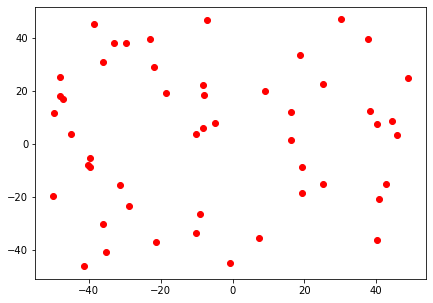

In [52]:
plt.rcParams["figure.figsize"] = (7, 5)
uniformes = simula_unif(50, 2, [-50, 50])
plt.scatter(uniformes[:,0], uniformes[:,1], c ='red')

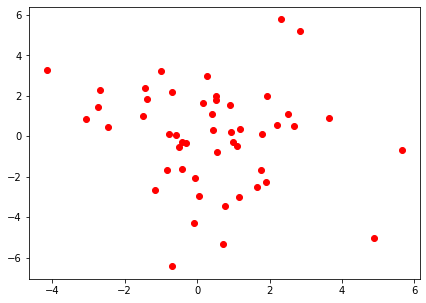

In [53]:
gaussianos = simula_gauss(50, 2, [5, 7])
plt.scatter(gaussianos[:,0], gaussianos[:,1], c ='red')

# EJERCICIO 1.2: Influencia del ruido

Generamos los puntos solicitados y la recta que usamos para etiquetarlos, los etiquetamos y graficamos:

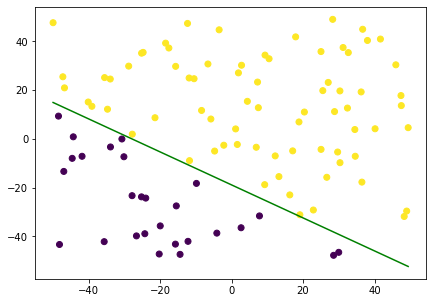

In [54]:
def f(x, y, a, b):
    return y - a*x - b

uniformes = simula_unif(100, 2, [-50, 50])
upla = uniformes.copy()
a, b = simula_recta([-50, 50])
etiquetas = signov(f(uniformes[:, 0], uniformes[:, 1], a, b))
plt.scatter(uniformes[:,0], uniformes[:,1], c =etiquetas)
x = np.linspace(min(uniformes[:,0]),max(uniformes[:,0]), 2)
plt.plot(x, a*x+b, c = 'green')


Introducimos un 10 por ciento de ruido en cada clase de forma aleatoria:

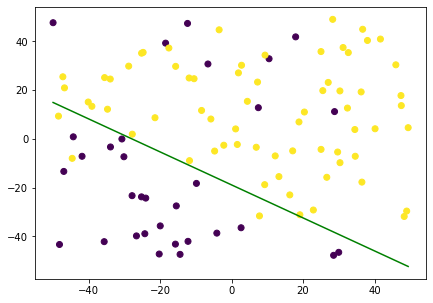

In [55]:
ruido = 0.1
etiquetasruidosas = etiquetas.copy()
pp = np.where(etiquetas==1)
pn = np.where(etiquetas==-1)
np.random.shuffle(pp)
np.random.shuffle(pn)
for i in range (0, math.ceil(ruido*len(pp[0]))):
    etiquetasruidosas[pp[0][i]]*=-1
for i in range (0, math.ceil(ruido*len(pn[0]))):
    etiquetasruidosas[pn[0][i]]*=-1
uplaruidosas = etiquetasruidosas.copy()
plt.scatter(uniformes[:,0], uniformes[:,1], c =etiquetasruidosas)
x = np.linspace(min(uniformes[:,0]),max(uniformes[:,0]), 2)
plt.plot(x, a*x+b, c = 'green')
    


Comprobamos que la recta generadora usada como clasificador esta limitada por el ruido

In [56]:
accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(etiquetas, etiquetasruidosas)]))/len(etiquetas) #Comprobamos la predicción con los valores reales, contamos en cuantas coinciden y dividimos entre la cantidad de datos
print("Tasa de acierto en clasificación "+str(accuracy))

Tasa de acierto en clasificación 0.89


Definamos las funciones que marcaran las nuevas fronteras de clasificación más complejas

In [57]:
def f1(x,y):
    return (x-10)**2+(y-20)**2-400
def f2(x,y):
    return 0.5*(x+10)**2+(y-20)**2-400
def f3(x,y):
    return 0.5*(x-10)**2-(y+20)**2-400
def f4(x,y):
    return y-20*x**2-5*x+3

A partir de aquí utilizamos dichas funciones como clasificadores sobre los datos ruidosos y lo graficamos con la ayuda de la función contour, mostramos las gráficas resultado y la exactitud de clasificación:

0.6


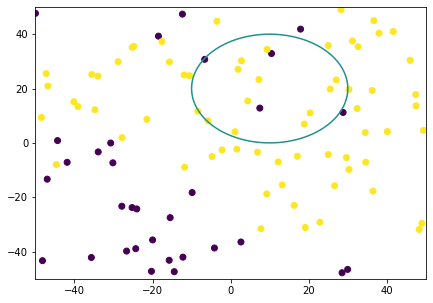

In [58]:
plt.scatter(uniformes[:,0], uniformes[:,1], c =etiquetasruidosas)
dom = np.linspace(-50, 50, 100)
domX, domY = np.meshgrid(dom, dom)
Z = f1(domX, domY)
plt.contour(domX, domY, Z, 0)

prediccion = signov(f1(uniformes[:,0], uniformes[:,1]))
accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, etiquetasruidosas)]))/len(prediccion)
print(accuracy)

0.52


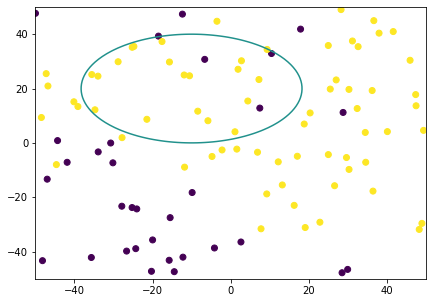

In [59]:
plt.scatter(uniformes[:,0], uniformes[:,1], c =etiquetasruidosas)
Z = f2(domX, domY)
plt.contour(domX, domY, Z, 0)

prediccion = signov(f2(uniformes[:,0], uniformes[:,1]))
accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, etiquetasruidosas)]))/len(prediccion)
print(accuracy)

0.25


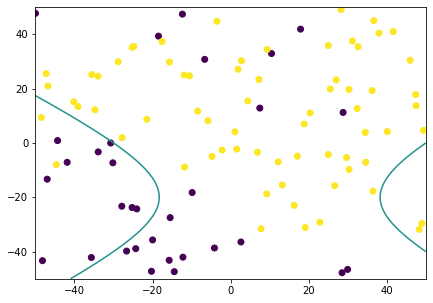

In [60]:
plt.scatter(uniformes[:,0], uniformes[:,1], c =etiquetasruidosas)
Z = f3(domX, domY)
plt.contour(domX, domY, Z, 0)

prediccion = signov(f3(uniformes[:,0], uniformes[:,1]))
accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, etiquetasruidosas)]))/len(prediccion)
print(accuracy)

0.32


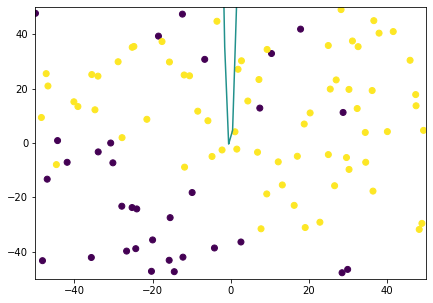

In [61]:
plt.scatter(uniformes[:,0], uniformes[:,1], c =etiquetasruidosas)
Z = f4(domX, domY)
plt.contour(domX, domY, Z, 0)

prediccion = signov(f4(uniformes[:,0], uniformes[:,1]))
accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, etiquetasruidosas)]))/len(prediccion)
print(accuracy)

Ahora vamos a hacer el procedimiento inverso, definiremos las etiquetas con las funciones e introducimos despues el ruido:

0.89


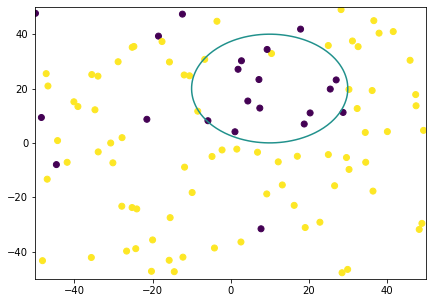

In [62]:
etiquetas = signov(f1(uniformes[:, 0], uniformes[:, 1]))
etiquetasruidosas = etiquetas.copy()
pp = np.where(etiquetas==1)
pn = np.where(etiquetas==-1)
np.random.shuffle(pp)
np.random.shuffle(pn)
for i in range (0, math.ceil(ruido*len(pp[0]))):
    etiquetasruidosas[pp[0][i]]*=-1
for i in range (0, math.ceil(ruido*len(pn[0]))):
    etiquetasruidosas[pn[0][i]]*=-1
    
plt.scatter(uniformes[:,0], uniformes[:,1], c =etiquetasruidosas)
Z = f1(domX, domY)
plt.contour(domX, domY, Z, 0)

prediccion = signov(f1(uniformes[:,0], uniformes[:,1]))
accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, etiquetasruidosas)]))/len(prediccion)
print(accuracy)

# EJERCICIO 2.1: ALGORITMO PERCEPTRON

In [63]:
def ajusta_PLA(datos, label, max_iter, vini):
    w = vini.copy() #Inicializamos el vector de pesos
    it = 0
    for i in range(0, max_iter):
        anterior_w = w.copy()
        
        for x, y in zip(datos, label):
            if signo(w.dot(x))!=y:   #Si no acierta clasificando muevo la frontera para hacerlo
                w += y*x
        it+=1
            
        if np.all(w==anterior_w):#Condición de parada, no han cambiado los pesos al recorrer todos los datos
            return w, it
    
    return w, it

Ejecutamos con los datos del apartado 1 sin ruido y veremos que convergerá con cualquier w inicial:

(array([0., 0., 0.]), array([661.        ,  23.20241712,  32.39163606]), 75)

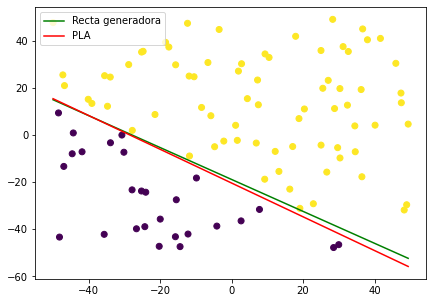

In [64]:
etiquetas = signov(f(upla[:, 0], upla[:, 1], a, b)) #Recuperamos las etiquetas originales
ini = np.zeros(3)
uniformes = np.hstack((np.ones((len(upla), 1)), upla))
w, it = ajusta_PLA(uniformes, etiquetas, 10000, ini)
plt.scatter(upla[:,0], upla[:,1], c =etiquetas)
dom = np.linspace(-50, 50, 100)
domX, domY = np.meshgrid(dom, dom)
x = np.linspace(min(upla[:,0]),max(upla[:,0]), 2)
plt.plot(x, a*x+b, c = 'green', label='Recta generadora')
plt.plot(x, (-w[0]-w[1]*x)/w[2], c = 'r', label='PLA')

plt.legend()
ini, w, it

Utilizamos inicializaciones aleatorias en [0, 1]^3 y realizamos un experimento para ver cuanto tarda en converger a la solución:

In [65]:
# Random initializations
iterations = []
iniciales = []
finales = []
for i in range(0,10):
    ini = np.random.uniform(0,1,(uniformes[0].size, 1)).T
    w, it = ajusta_PLA(uniformes, etiquetas, 1000, ini)
    iterations.append(it)
    iniciales.append(ini)
    finales.append(w)
print('Valor medio de iteraciones necesario para converger: {}'.format(np.mean(np.asarray(iterations))))
for i in range(0, 10):
    print(str(iterations[i])+' '+str(iniciales[i][0, 0])+' '+str(iniciales[i][0, 1])+' '+str(iniciales[i][0, 2])+' '+str(finales[i][0, 0])+' '+str(finales[i][0, 1])+' '+str(finales[i][0, 2])+'\n')

Valor medio de iteraciones necesario para converger: 110.9
60 0.6185135669120855 0.010364261335231939 0.538627282576347 555.618513566912 19.401335578745694 29.253726066231074

248 0.0030179566195963625 0.9511937854902045 0.905402033702778 1118.0030179566197 39.14140853304021 59.612740545136674

43 0.7959669419422694 0.9152743199147875 0.14555823115839706 458.79596694194225 15.331936323806644 23.83811624360694

72 0.15773006987053328 0.187631672902434 0.6224959022999211 609.1577300698705 24.124471527688215 33.26034218340073

129 0.9058094960083019 0.9899551783590737 0.7111224587658159 831.9058094960083 32.422309539276355 46.454101904511056

244 0.7318004091422953 0.9092932045442544 0.4008737323711209 1087.7318004091424 39.49082489078103 53.52108012168628

70 0.24985068022503676 0.17343017078712286 0.119457050333729 641.2498506802251 22.451965406844025 30.991155947353867

84 0.8126105880328287 0.14679237341724316 0.2642974827269007 663.8126105880328 22.117669803746367 30.864026947798706


Ahora usamos los datos con ruido que no son linealmente separables y el algoritmo oscilará en todo caso por construcción:

(array([0., 0., 0.]),
 array([660.        ,  23.95520539,  44.36098373]),
 400,
 0.86)

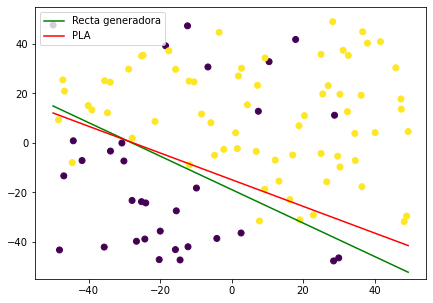

In [66]:
# Ahora con los datos del ejercicio 1.2.b
ini = np.zeros(3)
uniformes = np.hstack((np.ones((len(upla), 1)), upla))
w, it = ajusta_PLA(uniformes, uplaruidosas, 400, ini)
plt.scatter(upla[:,0], upla[:,1], c =uplaruidosas)
dom = np.linspace(-50, 50, 100)
domX, domY = np.meshgrid(dom, dom)
x = np.linspace(min(upla[:,0]),max(upla[:,0]), 2)
plt.ylim(-55, 55)
plt.plot(x, a*x+b, c = 'green', label='Recta generadora')
plt.plot(x, (-w[0]-w[1]*x)/w[2], c = 'r', label='PLA')
prediccion = signov(w[0] + w[1]*upla[:,0] + w[2]*upla[:,1])
accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, uplaruidosas)]))/len(prediccion)
plt.legend()
ini, w, it, accuracy

Probamos con más iteraciones para ver que no tiene porque mejorar, ya que no converge y el error no es monótono:

(array([0., 0., 0.]),
 array([649.        ,  35.97749082,  57.1093493 ]),
 800,
 0.83)

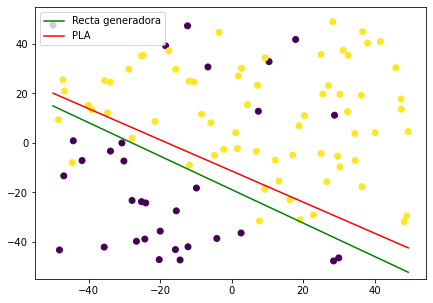

In [67]:
ini = np.zeros(3)
uniformes = np.hstack((np.ones((len(upla), 1)), upla))
w, it = ajusta_PLA(uniformes, uplaruidosas, 800, ini)
plt.scatter(upla[:,0], upla[:,1], c =uplaruidosas)
dom = np.linspace(-50, 50, 100)
domX, domY = np.meshgrid(dom, dom)
x = np.linspace(min(upla[:,0]),max(upla[:,0]), 2)
plt.ylim(-55, 55)
plt.plot(x, a*x+b, c = 'green', label='Recta generadora')
plt.plot(x, (-w[0]-w[1]*x)/w[2], c = 'r', label='PLA')
prediccion = signov(w[0] + w[1]*upla[:,0] + w[2]*upla[:,1])
accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, uplaruidosas)]))/len(prediccion)
plt.legend()
ini, w, it, accuracy

Repetimos el mismo experimento que antes con inicializaciones aleatorias:

In [68]:
# Random initializations
iterations = []
iniciales = []
finales = []
acierto = []
for i in range(0,10):
    ini = np.random.uniform(0,1,(uniformes[0].size, 1)).T
    w, it = ajusta_PLA(uniformes, uplaruidosas, 400, ini)
    prediccion = signov(w[0,0] + w[0,1]*upla[:,0] + w[0,2]*upla[:,1])
    accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, uplaruidosas)]))/len(prediccion)
    iterations.append(it)
    iniciales.append(ini)
    finales.append(w)
    acierto.append(accuracy)
print('Valor medio de iteraciones necesario para NO converger: {}'.format(np.mean(np.asarray(iterations))))
print('Valor medio de ACIERTO en clasificación: {}'.format(np.mean(np.asarray(acierto))))
for i in range(0, 10):
    print(str(iterations[i])+' '+str(acierto[i])+' '+str(iniciales[i][0, 0])+' '+str(iniciales[i][0, 1])+' '+str(iniciales[i][0, 2])+' '+str(finales[i][0, 0])+' '+str(finales[i][0, 1])+' '+str(finales[i][0, 2])+'\n')

Valor medio de iteraciones necesario para NO converger: 400.0
Valor medio de ACIERTO en clasificación: 0.842
400 0.84 0.9107728311738374 0.36655664385123443 0.43359232727316455 662.9107728311739 33.8349142080356 45.567971668144054

400 0.83 0.5122926922783614 0.9388864773697133 0.030949006271150714 653.5122926922784 32.79447803335713 65.75024154550101

400 0.81 0.7168786636316892 0.8910189542923389 0.027287223517468817 664.7168786636316 12.466580172031065 53.005811030226205

400 0.83 0.5220512472525107 0.3259898117700253 0.8594893208655858 649.5220512472525 39.80899429598726 71.3576803438973

400 0.84 0.5585165509225178 0.6902278681627478 0.45285349995153745 655.5585165509225 25.074489500879253 49.72346845485514

400 0.8 0.6283090375213571 0.2900968516874258 0.009348577966515781 647.6283090375214 14.847387600898482 56.853230706453886

400 0.89 0.5767559349870908 0.3114442141324628 0.5172675985011298 650.5767559349871 24.87320821360889 33.239443063180644

400 0.83 0.9164058530538978 0.4

# EJERCICIO 3: REGRESIÓN LOGÍSTICA CON STOCHASTIC GRADIENT DESCENT

In [69]:
def sigmoidFunction(x):
    return 1/(1 + np.exp(-x))

def Err(x,y,w):
    '''Entrada:
            x: Matriz de datos, tiene tantas filas como datos y columnas como características tiene cada dato
            y: Vector con las clases correspondientes a los datos x
            w: Vector de pesos para el cual se quiere calcular el error
            
        Salida:
            Error logístico'''
    return np.mean(np.log(1 + np.exp(-y*w.dot(x.T))))

# Función que calcula el gradiente del error

def gradError(x,y,w):
    '''Entrada:
            x: Matriz de datos, tiene tantas filas como datos y columnas como características. Se utiliza con un subconjunto de datos distinto en SGD cada vez.
            y: Vector con las clases correspondientes a los datos x
            w: Vector de pesos para el cual se quiere calcular el gradiente
            
        Salida:
            Derivada del error logístico'''
    suma=0
    for i in range(0, len(x)):
        suma+=(y[i]*x[i])/(1+np.exp(y[i]* w.dot(x[i].T)))
    return -suma / len(x)


def sgdRL(x, y, lr, max_iters, minibatchlen):
    '''Entrada:
            x: Matriz de datos, tiene tantas filas como datos y columnas como características.
            y: Vector con las clases correspondientes a los datos x
            lr: Tasa de aprendizaje(learning rate)
            max_iters: Número de iteraciones a realizar
            minibatchlen: Tamaño de los minibatches
            
        Salida:
            Vector de pesos para el problema de regresión'''
    w = np.zeros(x.shape[1])                                                        #Inicializamos a 0 el vector de pesos para comenzar a iterar
    w_old = w.copy()
    random_order = np.random.permutation(np.arange(x.shape[0]))                     #Realizamos una permutación aleatoria de tamaño el número de datos. Servirá para tomar despues conjuntos aleatorios de datos de tamaño minibatchlen.
    inicio = 0                                                                      #Inicializo la posición desde donde empezar a coger índices
    i = 0
    cambio = True                                                        
    while i < max_iters and cambio:
        if inicio + minibatchlen < x.shape[0]:                                      #Mientras no agotemos todos los datos, vamos tomando los índices en grupos del tamaño del minibatch
            minibatchpositions = random_order[inicio : inicio + minibatchlen]
        else:                                                                       #Si no hay datos suficientes para completar un minibatch, utilizamos los que queden.
            minibatchpositions = random_order[inicio : x.shape[0]]
        inicio = inicio + minibatchlen                                              #Actualizamos el índice de inicio para el siguiente mini-batch
        w = w - lr*gradError(x[minibatchpositions, :], y[minibatchpositions], w)    #Aplicamos el descenso de gradiente pero calculando el gradiente sólo con el minibatch considerado
        
        if inicio >= len(x):                                                         #Si he agotado los datos reinicio la permutación y el índice de inicio
            random_order = np.random.permutation(np.arange(x.shape[0]))
            inicio = 0
            i+=1                                                                    #Consideramos una iteración como un recorrido completo de los datos, por tanto la incrementamos
            if np.linalg.norm(w_old-w) < 0.01:
                cambio = False
            w_old = w.copy()
            
    return w, i

Generamos nuevos datos de entrenamiento y una recta aleatoria para etiquetarlos

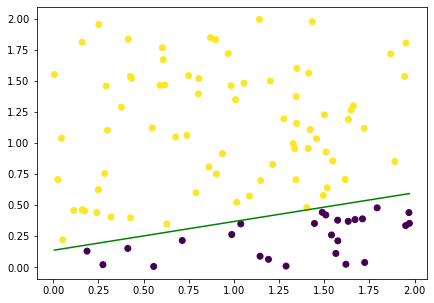

In [70]:
puntos = simula_unif(100, 2, [0, 2])
aleatorios = puntos[np.random.randint(100, size=2)]

a = (aleatorios[1][1]-aleatorios[1][0])/(aleatorios[0][1]-aleatorios[0][0])
b = aleatorios[1][0] - a*aleatorios[0][0]

def etiquetar(x, y):
    return y - a*x - b

etiquetados = signov(etiquetar(puntos[:, 0], puntos[:, 1]))
plt.scatter(puntos[:,0], puntos[:,1], c=etiquetados)
x = np.linspace(min(puntos[:,0]),max(puntos[:,0]), 2)
plt.plot(x, a*x+b, c = 'green')
datos = np.hstack((np.ones((len(puntos), 1)), puntos))

Consideramos un espacio paramétrico para testear el comportamiento del algoritmo, usamos un conjunto de test con 1000 puntos generados de la misma forma que antes, imprimimos una tabla con los errores y tasas de acierto que se analizará en la memoria para elegir los parámetros.

0.01 1 385 0.09062575633045036 0.99 0.09422629179941731 0.975
0.01 8 136 0.30138473367287066 0.9 0.2618471002461761 0.922
0.01 16 56 0.45390911790442073 0.74 0.3869833127128876 0.826
0.01 32 26 0.5550950682669311 0.74 0.5115545928413543 0.826
0.01 100 1 0.6907597305976877 0.74 0.6900664169449435 0.826
0.1 1 1008 0.020921115213164067 1.0 0.031253007141108284 0.991
0.1 8 439 0.07651958730164042 0.99 0.08234568630934148 0.976
0.1 16 301 0.116261704256782 0.98 0.11655974850223123 0.971
0.1 32 200 0.17109825664244804 0.97 0.15770624499773844 0.97
0.1 100 109 0.35320662263639396 0.81 0.3019008907413016 0.878
1 1 2713 0.0028707023520970864 1.0 0.014475828405831491 0.994
1 8 1070 0.017896201668621253 1.0 0.02857048883235886 0.991
1 16 766 0.02805048778177729 0.99 0.03848980488392274 0.99
1 32 531 0.04258646874189069 0.99 0.05231442654936733 0.986
1 100 384 0.09065387095389447 0.99 0.09443572989727644 0.975
10 1 496 0.0003074269830185585 1.0 0.019250066019565627 0.992
10 8 2518 0.00241618724500

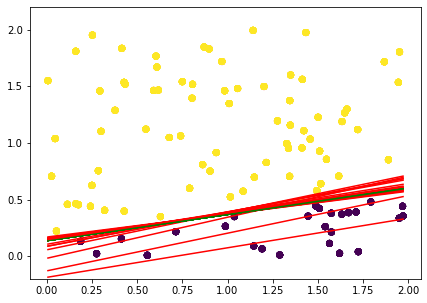

In [71]:
maxiter = 10000
etas = [0.01, 0.1, 1, 10]
minibatchlens = [1, 8, 16, 32, len(puntos)]

puntostest = simula_unif(1000, 2, [0, 2])
etiquetadostest = signov(etiquetar(puntostest[:, 0], puntostest[:, 1]))
datostest = np.hstack((np.ones((len(puntostest), 1)), puntostest))

for e in etas:
    for m in minibatchlens:
        w, i = sgdRL(datos, etiquetados, e, maxiter, m)
        plt.scatter(puntos[:,0], puntos[:,1], c=etiquetados)
        plt.ylim(-0.2, 2.2)
        x = np.linspace(min(puntos[:,0]),max(puntos[:,0]), 2)
        plt.plot(x, a*x+b, c = 'green', label='Recta generadora')
        plt.plot(x, (-w[0]-w[1]*x)/w[2], c = 'red', label='SGD Regresión Logística')
        prediccion = signov(w[0] + w[1]*puntos[:,0] + w[2]*puntos[:,1])
        accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, etiquetados)]))/len(prediccion)
        
        prediccion = signov(w[0] + w[1]*puntostest[:,0] + w[2]*puntostest[:,1])
        accuracytest = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, etiquetadostest)]))/len(prediccion)
        
        print(str(e)+' '+str(m)+' '+str(i)+' '+str(Err(datos, etiquetados, w))+' '+str(accuracy)+' '+str(Err(datostest, etiquetadostest, w))+' '+str(accuracytest))
        
        if e==0.1 and m==1:
            buenas=w.copy()

Mostramos la gráfica para una de las elecciones:

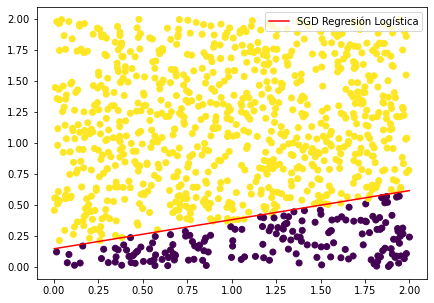

In [72]:
plt.scatter(puntostest[:,0], puntostest[:,1], c=etiquetadostest)
x = np.linspace(min(puntostest[:,0]),max(puntostest[:,0]), 2)
plt.plot(x, (-buenas[0]-buenas[1]*x)/buenas[2], c = 'red', label='SGD Regresión Logística')
plt.legend()
prediccion = signov(buenas[0] + buenas[1]*puntostest[:,0] + buenas[2]*puntostest[:,1])
accuracytest = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, etiquetadostest)]))/len(prediccion)


### Nota: Falta repetir el experimento 100 veces, se hace al final del Notebook para no modificar los resultados que ya se habían analizado en la memoria del apartado siguiente.

# BONUS : Clasificación de dígitos manuscritos

Cargamos los datos:

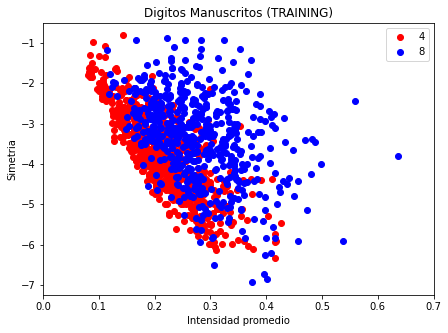

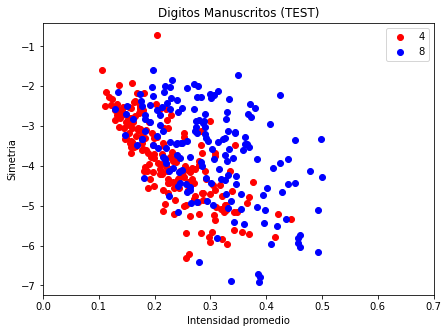

In [73]:
# Funcion para leer los datos
def readData(file_x, file_y, digits, labels):
	# Leemos los ficheros	
	datax = np.load(file_x)
	datay = np.load(file_y)
	y = []
	x = []	
	# Solo guardamos los datos cuya clase sea la digits[0] o la digits[1]
	for i in range(0,datay.size):
		if datay[i] == digits[0] or datay[i] == digits[1]:
			if datay[i] == digits[0]:
				y.append(labels[0])
			else:
				y.append(labels[1])
			x.append(np.array([1, datax[i][0], datax[i][1]]))
			
	x = np.array(x, np.float64)
	y = np.array(y, np.float64)
	
	return x, y

# Lectura de los datos de entrenamiento
x, y = readData('datos/X_train.npy', 'datos/y_train.npy', [4,8], [-1,1])
# Lectura de los datos para el test
x_test, y_test = readData('datos/X_test.npy', 'datos/y_test.npy', [4,8], [-1,1])


#mostramos los datos
fig, ax = plt.subplots()
ax.plot(np.squeeze(x[np.where(y == -1),1]), np.squeeze(x[np.where(y == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x[np.where(y == 1),1]), np.squeeze(x[np.where(y == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TRAINING)')
ax.set_xlim((0, 0.7))
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(np.squeeze(x_test[np.where(y_test == -1),1]), np.squeeze(x_test[np.where(y_test == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x_test[np.where(y_test == 1),1]), np.squeeze(x_test[np.where(y_test == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TEST)')
ax.set_xlim((0, 0.7))
plt.legend()
plt.show()

Definimos las funciones asociadas a regresión lineal de la práctica anterior:

In [74]:
def ErrCuadratico(x,y,w):
    '''Entrada:
            x: Matriz de datos, tiene tantas filas como datos y columnas como características tiene cada dato
            y: Vector con las clases correspondientes a los datos x
            w: Vector de pesos para el cual se quiere calcular el error
            
        Salida:
            Error cuadrático medio'''
    return (np.linalg.norm(x.dot(w) - y)**2)/len(x)

In [75]:
def pseudoinverse(x, y):
    '''Entrada:
            x: Matriz de datos, tiene tantas filas como datos y columnas como características.
            y: Vector con las clases correspondientes a los datos x'''
    u, d, v = np.linalg.svd(x)
    return v.transpose() @ np.diag(d**(-2)) @ v @ x.transpose() @ y

Implementamos dos funciones para generar métricas, por un lado la tasa de acierto en clasificación y por otro el cálculo de la matriz de confusión que muestra como acierta y como se equivoca un modelo con respecto a cada clase:

In [76]:
def getAccuracy(x, y, w):
    prediccion = signov(w[0] + w[1]*x[:,1] + w[2]*x[:,2])
    accuracy = np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, y)]))/len(prediccion)
    return accuracy

def getConfusionMatrix(x, y, w):
    prediccion = signov(w[0] + w[1]*x[:,1] + w[2]*x[:,2])
    tp=0
    fp=0
    tn=0
    fn=0
    for a, b in zip(prediccion, y):
        if b==1 and a==1:
            tp+=1
        if b==-1 and a==-1:
            tn+=1            
        if b==1 and a==-1:
            fn+=1
        if b==-1 and a==1:
            fp+=1            
    return np.array([[tp, fp], [fn, tn]])

## Pseudoinversa

Aplicamos regresión lineal a nuestros datos:

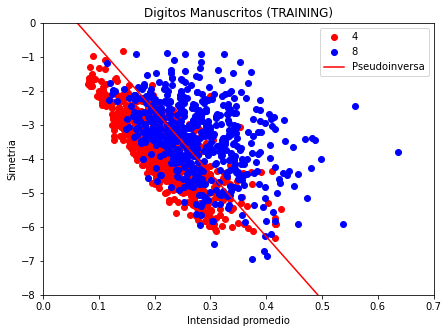

(0.7721943048576214,
 0.6428532963367777,
 array([[339,  69],
        [203, 583]]))

In [77]:
w = pseudoinverse(x, y)
pesosregresion = w.copy()
fig, ax = plt.subplots()
ax.plot(np.squeeze(x[np.where(y == -1),1]), np.squeeze(x[np.where(y == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x[np.where(y == 1),1]), np.squeeze(x[np.where(y == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TRAINING)')
ax.set_xlim((0, 0.7))
ax.set_ylim((-8, 0))
t = np.linspace(0, 1, 2)
ax.plot(t, (-w[0]-w[1]*t)/w[2], c = 'r', label='Pseudoinversa')
plt.legend()
plt.show()
accuracy = getAccuracy(x, y, w)
einpi = accuracy
accuracy, ErrCuadratico(x, y, w), getConfusionMatrix(x, y, w)

Mostramos los resultados para Pseudoinversa en Test:

(0.7486338797814208,
 0.7087148141159975,
 array([[107,  33],
        [ 59, 167]]))

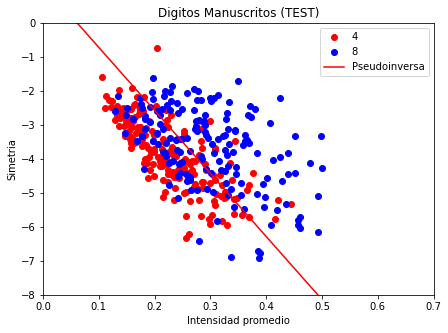

In [78]:
fig, ax = plt.subplots()
ax.plot(np.squeeze(x_test[np.where(y_test == -1),1]), np.squeeze(x_test[np.where(y_test == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x_test[np.where(y_test == 1),1]), np.squeeze(x_test[np.where(y_test == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TEST)')
ax.set_xlim((0, 0.7))
ax.set_ylim((-8, 0))
t = np.linspace(0, 1, 2)
ax.plot(t, (-w[0]-w[1]*t)/w[2], c = 'r', label='Pseudoinversa')
plt.legend()
accuracy = getAccuracy(x_test, y_test, w)
etestpi = accuracy
accuracy, ErrCuadratico(x_test, y_test, w), getConfusionMatrix(x_test, y_test, w)

## PLA 

Aplicamos PLA a nuestros datos:

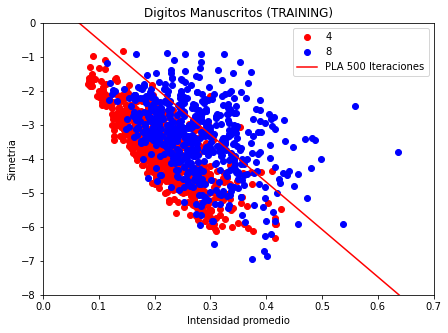

(0.6909547738693468,
 342.5874003549221,
 array([[181,   8],
        [361, 644]]))

In [79]:
w, it = ajusta_PLA(x, y, 500, np.zeros(3))
fig, ax = plt.subplots()
ax.plot(np.squeeze(x[np.where(y == -1),1]), np.squeeze(x[np.where(y == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x[np.where(y == 1),1]), np.squeeze(x[np.where(y == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TRAINING)')
ax.set_xlim((0, 0.7))
ax.set_ylim((-8, 0))
t = np.linspace(0, 1, 2)
ax.plot(t, (-w[0]-w[1]*t)/w[2], c = 'r', label='PLA '+str(it)+' Iteraciones')
plt.legend()
plt.show()
accuracy = getAccuracy(x, y, w)
einpla = accuracy
accuracy, ErrCuadratico(x, y, w), getConfusionMatrix(x, y, w)

Obtenemos los resultados de PLA en test:

(0.6994535519125683,
 331.84278957448316,
 array([[ 59,   3],
        [107, 197]]))

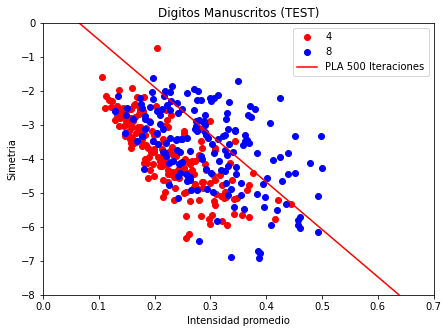

In [80]:
fig, ax = plt.subplots()
ax.plot(np.squeeze(x_test[np.where(y_test == -1),1]), np.squeeze(x_test[np.where(y_test == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x_test[np.where(y_test == 1),1]), np.squeeze(x_test[np.where(y_test == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TEST)')
ax.set_xlim((0, 0.7))
ax.set_ylim((-8, 0))
t = np.linspace(0, 1, 2)
ax.plot(t, (-w[0]-w[1]*t)/w[2], c = 'r', label='PLA '+str(it)+' Iteraciones')
plt.legend()
accuracy = getAccuracy(x_test, y_test, w)
etestpla = accuracy
accuracy, ErrCuadratico(x_test, y_test, w), getConfusionMatrix(x_test, y_test, w)

## PLA POCKET

Implementamos esta mejora del Perceptrón que simplemente almacena la mejor solución en cada momento, esto tiene el problema de que debe evaluarse la solución al final de cada época:

In [81]:
def ajusta_POCKET(datos, label, max_iter, vini):
    w = vini.copy()
    mejor = w.copy()
    einmejor = 1 - getAccuracy(datos, label, mejor)
    it=0
    for i in range(0, max_iter):
        anterior_w = w.copy()

        for x, y in zip(datos, label):
            if signo(w.dot(x))!=y:
                w += y*x
        it+=1
        err = 1 - getAccuracy(datos, label, w)   #Calculamos el error
        if err < einmejor:                       #Guardamos la nueva solución si es mejor
            mejor = w.copy()
            einmejor = err
        if np.all(w == anterior_w):  # No hay cambios
            return mejor, it

    return mejor, it

Lo aplicamos a nuestros datos:

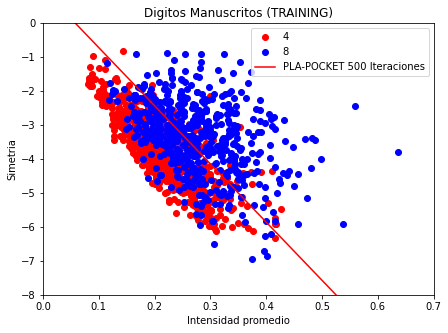

(0.7713567839195979,
 102.36676318727653,
 array([[315,  46],
        [227, 606]]))

In [82]:
w, it = ajusta_POCKET(x, y, 500, np.zeros(3))
fig, ax = plt.subplots()
ax.plot(np.squeeze(x[np.where(y == -1),1]), np.squeeze(x[np.where(y == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x[np.where(y == 1),1]), np.squeeze(x[np.where(y == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TRAINING)')
ax.set_xlim((0, 0.7))
ax.set_ylim((-8, 0))
t = np.linspace(0, 1, 2)
ax.plot(t, (-w[0]-w[1]*t)/w[2], c = 'r', label='PLA-POCKET '+str(it)+' Iteraciones')
plt.legend()
plt.show()
accuracy = getAccuracy(x, y, w)
einpocket = accuracy
accuracy, ErrCuadratico(x, y, w), getConfusionMatrix(x, y, w)

Mostramos los resultados de PLA-POCKET en test:

(0.7540983606557377,
 102.37246636118563,
 array([[ 97,  21],
        [ 69, 179]]))

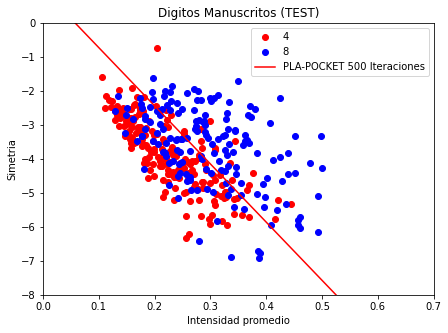

In [83]:
fig, ax = plt.subplots()
ax.plot(np.squeeze(x_test[np.where(y_test == -1),1]), np.squeeze(x_test[np.where(y_test == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x_test[np.where(y_test == 1),1]), np.squeeze(x_test[np.where(y_test == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TEST)')
ax.set_xlim((0, 0.7))
ax.set_ylim((-8, 0))
t = np.linspace(0, 1, 2)
ax.plot(t, (-w[0]-w[1]*t)/w[2], c = 'r', label='PLA-POCKET '+str(it)+' Iteraciones')
plt.legend()
accuracy = getAccuracy(x_test, y_test, w)
etestpocket = accuracy
accuracy, ErrCuadratico(x_test, y_test, w), getConfusionMatrix(x_test, y_test, w)

## Regresión Logística SGD

Hacemos lo mismo con regresión logística con distintas tasas, mantenemos las mejores:

### Learning Rate 0.01

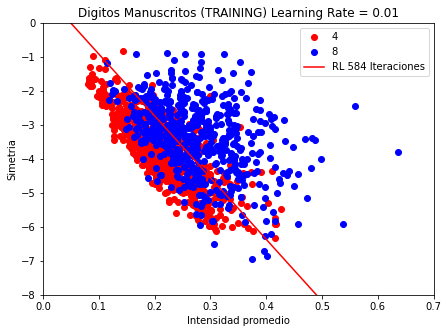

(0.7780569514237856,
 0.4636780517746734,
 array([[369,  92],
        [173, 560]]))

In [84]:
w, it = sgdRL(x, y, 0.01, 10000, 1)
fig, ax = plt.subplots()
ax.plot(np.squeeze(x[np.where(y == -1),1]), np.squeeze(x[np.where(y == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x[np.where(y == 1),1]), np.squeeze(x[np.where(y == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TRAINING) Learning Rate = 0.01')
ax.set_xlim((0, 0.7))
ax.set_ylim((-8, 0))
t = np.linspace(0, 1, 2)
ax.plot(t, (-w[0]-w[1]*t)/w[2], c = 'r', label='RL '+str(it)+' Iteraciones')
plt.legend()
plt.show()
accuracy = getAccuracy(x, y, w)
einlr = accuracy
accuracy, Err(x, y, w), getConfusionMatrix(x, y, w)

(0.7486338797814208,
 0.5258050826382824,
 array([[113,  39],
        [ 53, 161]]))

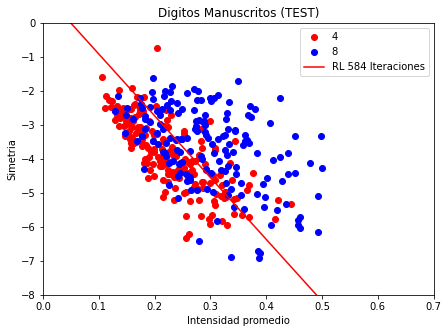

In [85]:
fig, ax = plt.subplots()
ax.plot(np.squeeze(x_test[np.where(y_test == -1),1]), np.squeeze(x_test[np.where(y_test == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x_test[np.where(y_test == 1),1]), np.squeeze(x_test[np.where(y_test == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TEST)')
ax.set_xlim((0, 0.7))
ax.set_ylim((-8, 0))
t = np.linspace(0, 1, 2)
ax.plot(t, (-w[0]-w[1]*t)/w[2], c = 'r', label='RL '+str(it)+' Iteraciones')
plt.legend()
accuracy = getAccuracy(x_test, y_test, w)
etestlr = accuracy
accuracy, Err(x_test, y_test, w), getConfusionMatrix(x_test, y_test, w)

### Learning Rate 0.1

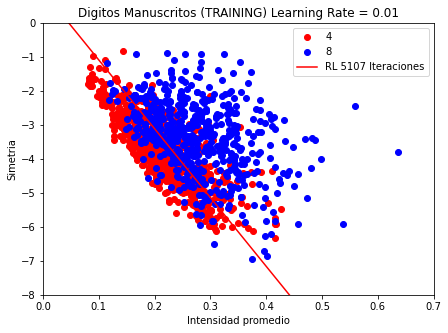

(0.7721943048576214,
 0.49720760129728764,
 array([[437, 167],
        [105, 485]]))

In [86]:
w, it = sgdRL(x, y, 0.1, 10000, 1)
fig, ax = plt.subplots()
ax.plot(np.squeeze(x[np.where(y == -1),1]), np.squeeze(x[np.where(y == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x[np.where(y == 1),1]), np.squeeze(x[np.where(y == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TRAINING) Learning Rate = 0.01')
ax.set_xlim((0, 0.7))
ax.set_ylim((-8, 0))
t = np.linspace(0, 1, 2)
ax.plot(t, (-w[0]-w[1]*t)/w[2], c = 'r', label='RL '+str(it)+' Iteraciones')
plt.legend()
plt.show()
accuracy = getAccuracy(x, y, w)
accuracy, Err(x, y, w), getConfusionMatrix(x, y, w)

(0.7049180327868853,
 0.6002401464230601,
 array([[129,  71],
        [ 37, 129]]))

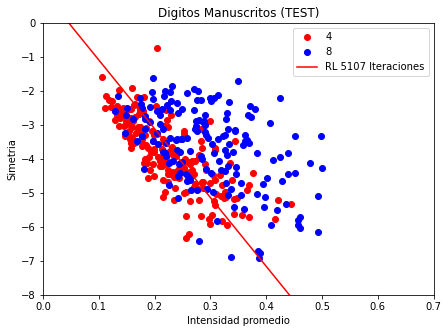

In [87]:
fig, ax = plt.subplots()
ax.plot(np.squeeze(x_test[np.where(y_test == -1),1]), np.squeeze(x_test[np.where(y_test == -1),2]), 'o', color='red', label='4')
ax.plot(np.squeeze(x_test[np.where(y_test == 1),1]), np.squeeze(x_test[np.where(y_test == 1),2]), 'o', color='blue', label='8')
ax.set(xlabel='Intensidad promedio', ylabel='Simetria', title='Digitos Manuscritos (TEST)')
ax.set_xlim((0, 0.7))
ax.set_ylim((-8, 0))
t = np.linspace(0, 1, 2)
ax.plot(t, (-w[0]-w[1]*t)/w[2], c = 'r', label='RL '+str(it)+' Iteraciones')
plt.legend()
accuracy = getAccuracy(x_test, y_test, w)
accuracy, Err(x_test, y_test, w), getConfusionMatrix(x_test, y_test, w)

## Inicialización con los pesos de regresión

Ahora utilizaremos como inicialización en todos los algoritmos los pesos que proporciona la pseudoinversa:

PLA

In [88]:
w, it = ajusta_PLA(x, y, 500, pesosregresion)
accuracy = getAccuracy(x, y, w)
it, accuracy, ErrCuadratico(x, y, w), getConfusionMatrix(x, y, w)

(500,
 0.7043551088777219,
 324.7321442965419,
 array([[198,   9],
        [344, 643]]))

In [89]:
accuracy = getAccuracy(x_test, y_test, w)
accuracy, ErrCuadratico(x_test, y_test, w), getConfusionMatrix(x_test, y_test, w)

(0.7021857923497268,
 314.3169035880842,
 array([[ 62,   5],
        [104, 195]]))

POCKET

In [90]:
w, it = ajusta_POCKET(x, y, 20, pesosregresion)
accuracy = getAccuracy(x, y, w)
it, accuracy, ErrCuadratico(x, y, w), getConfusionMatrix(x, y, w)

(20,
 0.7747068676716918,
 38.69972431025628,
 array([[340,  67],
        [202, 585]]))

In [91]:
accuracy = getAccuracy(x_test, y_test, w)
accuracy, ErrCuadratico(x_test, y_test, w), getConfusionMatrix(x_test, y_test, w)

(0.7459016393442623,
 40.74009067556707,
 array([[107,  34],
        [ 59, 166]]))

RL: En este caso hay que modificar el algoritmo para que se le pueda pasar un vector de inicialización:

In [92]:
def sgdRLini(x, y, lr, max_iters, minibatchlen, pesos):
    '''Entrada:
            x: Matriz de datos, tiene tantas filas como datos y columnas como características.
            y: Vector con las clases correspondientes a los datos x
            lr: Tasa de aprendizaje(learning rate)
            max_iters: Número de iteraciones a realizar
            minibatchlen: Tamaño de los minibatches
            epsilon: Error admisible para terminar antes
            
        Salida:
            Vector de pesos para el problema de regresión'''
    w = pesos.copy()                                                        #Inicializamos a 0 el vector de pesos para comenzar a iterar
    w_old = w.copy()
    random_order = np.random.permutation(np.arange(x.shape[0]))                     #Realizamos una permutación aleatoria de tamaño el número de datos. Servirá para tomar despues conjuntos aleatorios de datos de tamaño minibatchlen.
    inicio = 0                                                                      #Inicializo la posición desde donde empezar a coger índices
    i = 0
    cambio = True                                                        
    while i < max_iters and cambio:
        if inicio + minibatchlen < x.shape[0]:                                      #Mientras no agotemos todos los datos, vamos tomando los índices en grupos del tamaño del minibatch
            minibatchpositions = random_order[inicio : inicio + minibatchlen]
        else:                                                                       #Si no hay datos suficientes para completar un minibatch, utilizamos los que queden.
            minibatchpositions = random_order[inicio : x.shape[0]]
        inicio = inicio + minibatchlen                                              #Actualizamos el índice de inicio para el siguiente mini-batch
        w = w - lr*gradError(x[minibatchpositions, :], y[minibatchpositions], w)    #Aplicamos el descenso de gradiente pero calculando el gradiente sólo con el minibatch considerado
        
        if inicio >= len(x):                                                         #Si he agotado los datos reinicio la permutación y el índice de inicio
            random_order = np.random.permutation(np.arange(x.shape[0]))
            inicio = 0
            i+=1                                                                    #Consideramos una iteración como un recorrido completo de los datos, por tanto la incrementamos
            if np.linalg.norm(w_old-w) < 0.01:
                cambio = False
            w_old = w.copy()
            
    return w, i

In [93]:
w, it = sgdRLini(x, y, 0.01, 10000, 1, pesosregresion)
accuracy = getAccuracy(x, y, w)
it, accuracy, ErrCuadratico(x, y, w), getConfusionMatrix(x, y, w)

(563,
 0.7680067001675042,
 2.6977790784247215,
 array([[327,  62],
        [215, 590]]))

In [94]:
accuracy = getAccuracy(x_test, y_test, w)
accuracy, Err(x_test, y_test, w), getConfusionMatrix(x_test, y_test, w)

(0.7513661202185792,
 0.5330510596161802,
 array([[101,  26],
        [ 65, 174]]))

## Cotas de error fuera de la muestra

Calculamos las cotas de error teóricas dadas por las desigualdades explicadas en la memoria:

In [95]:
delta = 0.05
dvc = 3
def cotatest(error, N):
    return error + np.sqrt(np.log(2/delta)/(2*N))
def cotavapnik(error, N):
    return error + np.sqrt(8*np.log((4*(2*N)**(dvc) + 1)/delta)/N)

In [96]:
print("Cotas de Hoeffding:\n")
print("Cota Regresión Lineal: "+str(cotatest(1-etestpi, len(x))))
print("Cota PLA: "+str(cotatest(1-etestpla, len(x))))
print("Cota PLA-POCKET: "+str(cotatest(1-etestpocket, len(x))))
print("Cota Regresión Logística: "+str(cotatest(1-etestlr, len(x))))

Cotas de Hoeffding:

Cota Regresión Lineal: 0.29066951562320636
Cota PLA: 0.3398498434920589
Cota PLA-POCKET: 0.28520503474888953
Cota Regresión Logística: 0.29066951562320636


In [97]:
print("Cotas de Vapnik-Chervonenkis:\n")
print("Cota Regresión Lineal: "+str(cotavapnik(1-einpi, len(x))))
print("Cota PLA: "+str(cotavapnik(1-einpla, len(x))))
print("Cota PLA-POCKET: "+str(cotavapnik(1-einpocket, len(x))))
print("Cota Regresión Logística: "+str(cotavapnik(1-einlr, len(x))))

Cotas de Vapnik-Chervonenkis:

Cota Regresión Lineal: 0.6587422006126541
Cota PLA: 0.7399817316009287
Cota PLA-POCKET: 0.6595797215506776
Cota Regresión Logística: 0.6528795540464899


## Experimento 100 veces Regresión Logística

Retomamos el experimento del segundo ejercicio, ejecutaremos 100 veces regresión logística para obtener el promedio del error y de épocas necesarias para converger, usaremos $\eta=10$ y batches unitarios:

Nota: La ejecución se prolonga en torno a unos 5 minutos

In [98]:
maxiter = 10000
e = 10
m = 1

puntos = simula_unif(100, 2, [0, 2]) #Simulamos otros 100 puntos y los etiquetamos con la misma recta que antes
etiquetados = signov(etiquetar(puntos[:, 0], puntos[:, 1]))
datos = np.hstack((np.ones((len(puntos), 1)), puntos))

puntostest = simula_unif(1000, 2, [0, 2]) #Generamos otro conjunto de test
etiquetadostest = signov(etiquetar(puntostest[:, 0], puntostest[:, 1]))
datostest = np.hstack((np.ones((len(puntostest), 1)), puntostest))

epocas = []
ein = []
eout = []
ain = []
aout = []

for a in range(0, 100):
    #print(a)
    w, i = sgdRL(datos, etiquetados, e, maxiter, m) #Entreno
    
    epocas.append(i)

    prediccion = signov(w[0] + w[1]*puntos[:,0] + w[2]*puntos[:,1])
    ain.append(np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, etiquetados)]))/len(prediccion))
    ein.append(Err(datos, etiquetados, w))
    
    prediccion = signov(w[0] + w[1]*puntostest[:,0] + w[2]*puntostest[:,1])
    aout.append(np.count_nonzero(np.array([p==r for (p, r) in zip(prediccion, etiquetadostest)]))/len(prediccion))
    eout.append(Err(datostest, etiquetadostest, w))

it = np.mean(np.asarray(epocas))
ei = np.mean(np.asarray(ein))
ai = np.mean(np.asarray(ain))
eo = np.mean(np.asarray(eout))
ao = np.mean(np.asarray(aout))
print(str(e)+' '+str(m)+' '+str(it)+' '+str(ei)+' '+str(ai)+' '+str(eo)+' '+str(ao))
        

10 1 1796.14 0.0007209614925582897 1.0 0.01373522698288078 0.99542
